<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [ ]:
#@title Install Packages
!pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
!pip install git+https://github.com/VLL-HD/FrEIA.git

In [ ]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist
# Pyro Settings


# GPyTorch Settings
import gpytorch

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

2021-06-26 21:11:32,187:INFO:Using device: cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [ ]:
from sklearn.datasets import make_moons

n_train = 1_000
data, label = make_moons(n_samples=n_train, noise=0.00)

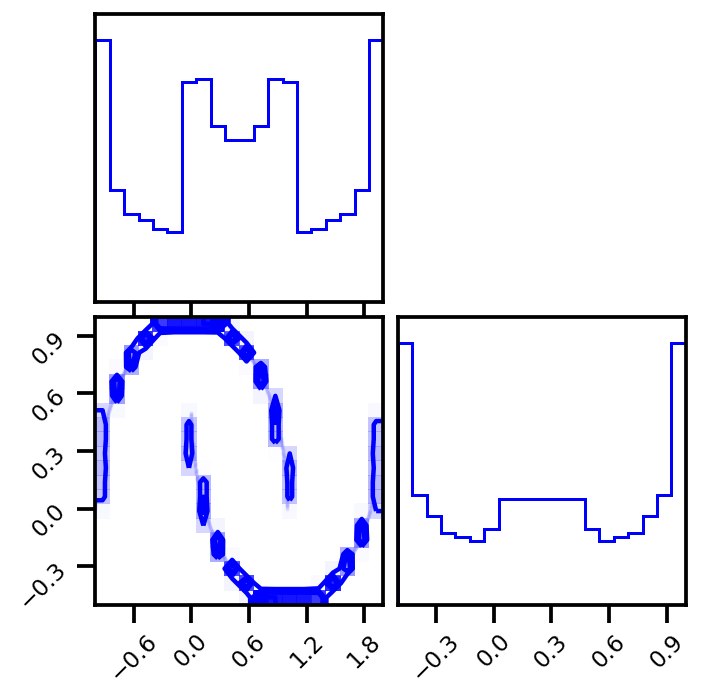

In [ ]:
fig = corner.corner(data, hist_factor=2, color="blue")

## Model

In [ ]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

N_DIM = 2

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(
        Fm.AllInOneBlock, 
        subnet_constructor=subnet_fc, 
        permute_soft=True, 
        gin_block=False, 
        learned_householder_permutation=2
        )

base_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#### Initial Transformation

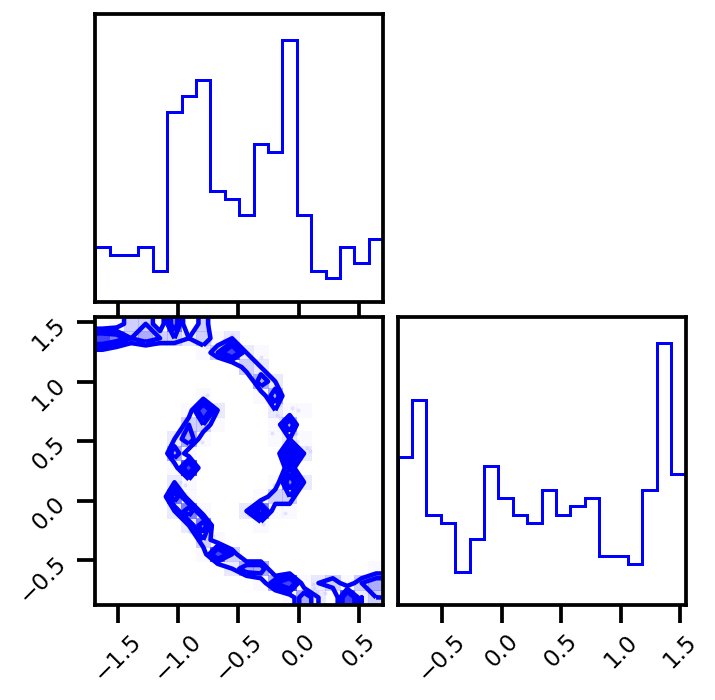

In [ ]:
x = torch.Tensor(data)
z, log_jac_det = inn(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="blue")

## Training

In [ ]:
num_epochs = 2_500

# gamma = 0.1
# lr_decay = gamma ** (1 / num_epochs)

initial_lr = 1e-2
optimizer = torch.optim.Adam(inn.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[
                0.5 * num_epochs, 
                0.75 * num_epochs,
                0.9 * num_epochs,
                ], 
    gamma=0.1)

In [ ]:
from tqdm.notebook import trange

In [ ]:
BATCHSIZE = 256


losses = []
# a very basic training loop
with trange(num_epochs) as pbar:
    for i in pbar:
        optimizer.zero_grad()
        # sample data from the moons distribution
        data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
        x = torch.Tensor(data)
        # pass to INN and get transformed variable z and log Jacobian determinant
        z, log_jac_det = inn(x)
        # calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5*torch.sum(z**2, 1) - log_jac_det
        loss = loss.mean() / N_DIM
        # loss = base_dist.log_prob(z).sum(1) + log_jac_det
        # loss = -loss.mean()
        # backpropagate and update the weights
        pbar.set_description(f"NLL Loss: {loss.item():.4f}")
        losses.append(loss.item())
        loss.backward()
        # gradient norm
        torch.nn.utils.clip_grad_norm_(inn.parameters(), max_norm=1.0, norm_type=2)
        optimizer.step()
        scheduler.step()




  0%|          | 0/2500 [00:00<?, ?it/s]

#### Losses

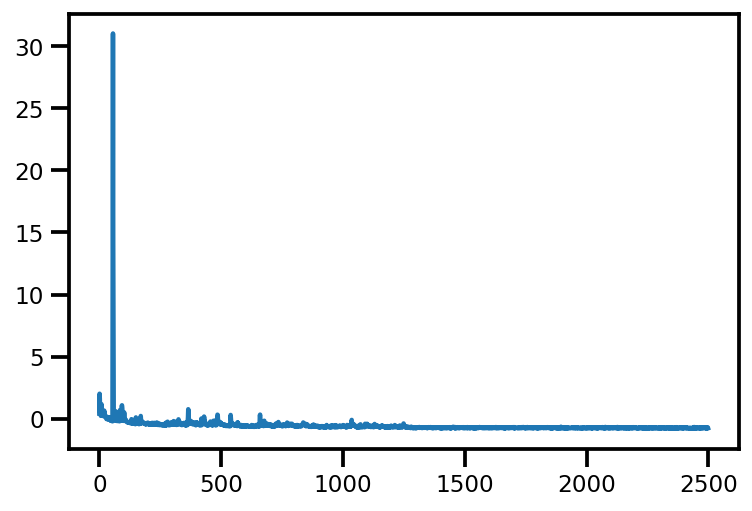

In [ ]:
plt.plot(losses)

#### Latent Space

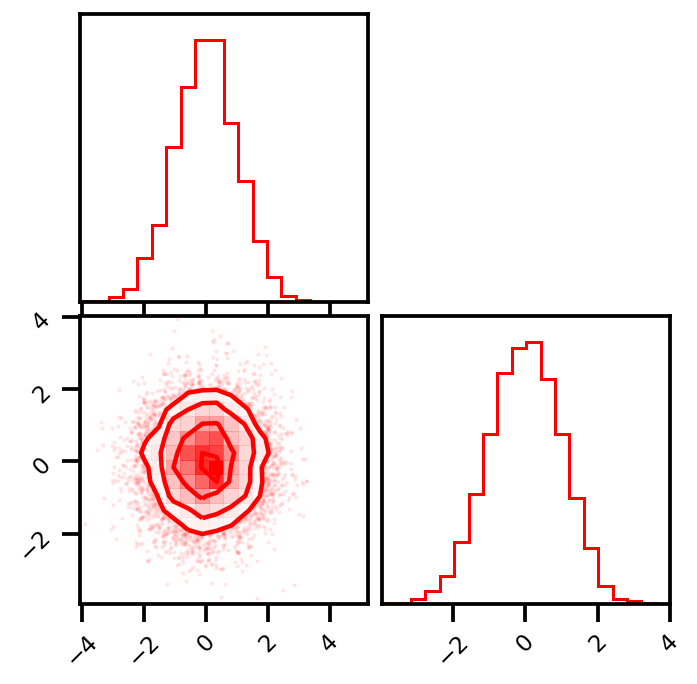

In [ ]:
n_test = 10_000
data_test, label = make_moons(n_samples=n_test, noise=0.05)
x = torch.Tensor(data_test)
z, log_jac_det = inn(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")

#### Inverse Transform

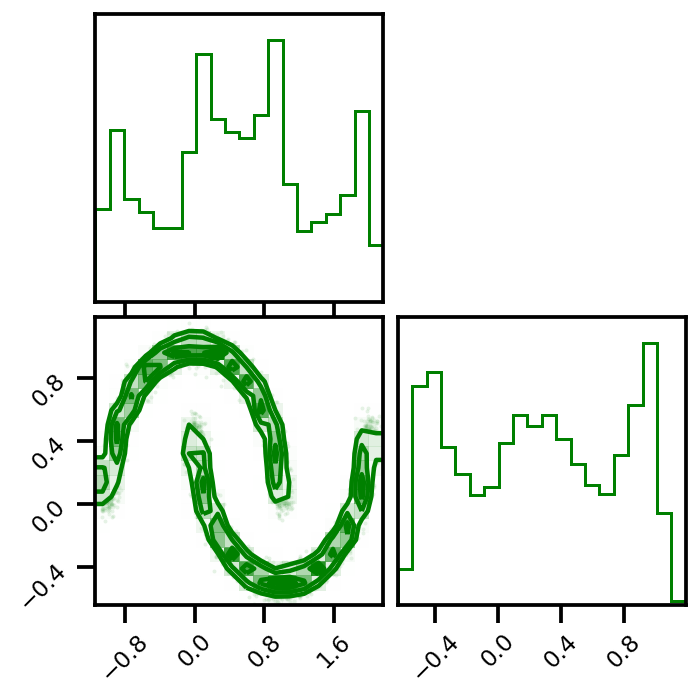

In [ ]:
x_ori, _ = inn(z, rev=True)

fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")

#### Sampling

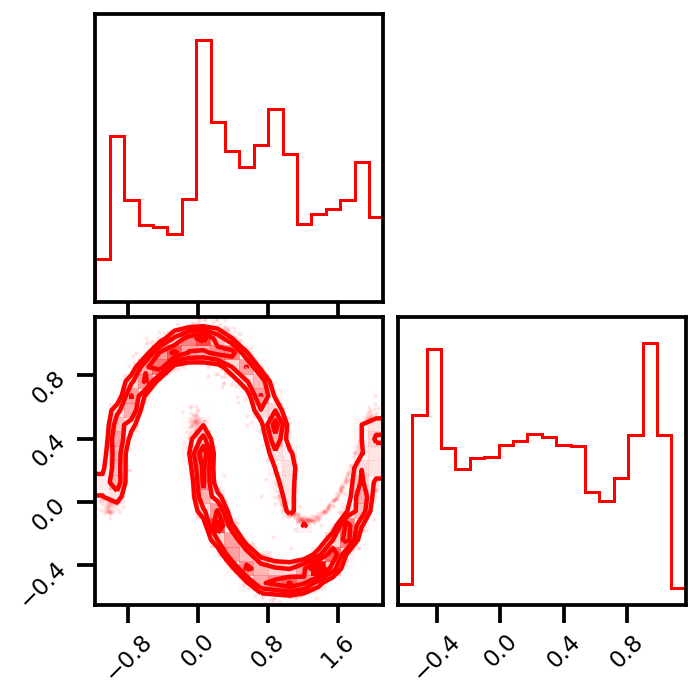

In [ ]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, N_DIM)
samples, _ = inn(z, rev=True)

fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")

## Conditional 

#### Model

In [ ]:
# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(
        Fm.AllInOneBlock, 
        subnet_constructor=subnet_fc, 
        permute_soft=True, 
        gin_block=False, 
        learned_householder_permutation=2,
        cond=0, cond_shape=(1,))

base_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

In [ ]:
data, label = make_moons(n_samples=n_train, noise=0.05)
x = torch.Tensor(data)
y = torch.Tensor(label[:, None])
z, log_jac_det = inn(x, c=[y])

#### Training

In [ ]:
optimizer = torch.optim.Adam(inn.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[
                0.5 * num_epochs, 
                0.75 * num_epochs,
                0.9 * num_epochs,
                ], 
    gamma=0.1)

In [ ]:
BATCHSIZE = 256


losses = []
# a very basic training loop
with trange(num_epochs) as pbar:
    for i in pbar:
        optimizer.zero_grad()
        # sample data from the moons distribution
        data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
        x = torch.Tensor(data)
        y = torch.Tensor(label)[:, None]
        # pass to INN and get transformed variable z and log Jacobian determinant
        z, log_jac_det = inn(x, c=[y])
        # calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5*torch.sum(z**2, 1) - log_jac_det
        # loss = base_dist.log_prob(z).sum(1) - log_jac_det
        loss = loss.mean() / N_DIM
        # backpropagate and update the weights
        pbar.set_description(f"NLL Loss: {loss.item():.4f}")
        losses.append(loss.item())
        loss.backward()
        # gradient norm
        torch.nn.utils.clip_grad_norm_(inn.parameters(), max_norm=1.0, norm_type=2)
        optimizer.step()
        scheduler.step()


  0%|          | 0/2500 [00:00<?, ?it/s]

#### Latent Space

In [ ]:
n_test = 10_000
data_test, label_test = make_moons(n_samples=n_test, noise=0.05)
x = torch.Tensor(data_test)
y = torch.Tensor(label_test[:, None])
z, log_jac_det = inn(x, c=[y])

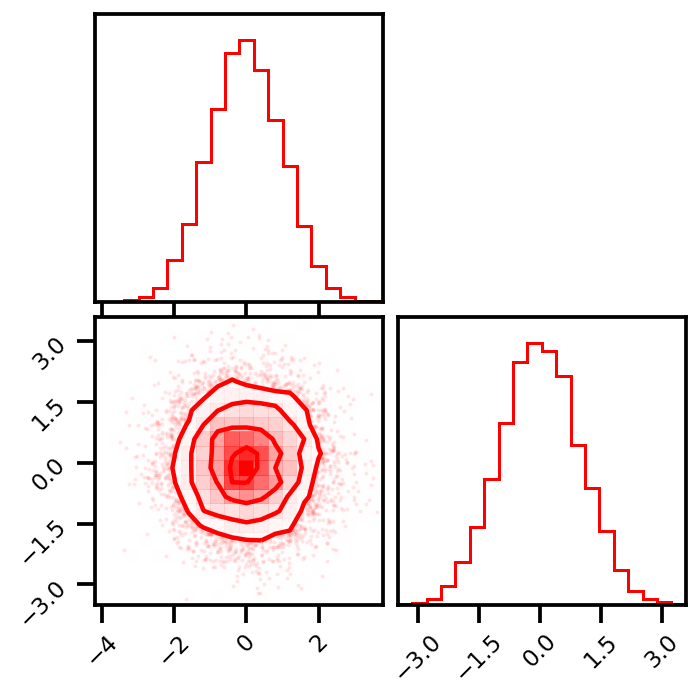

In [ ]:
fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")

#### Inverse Transform

In [ ]:
x_ori, _ = inn(z, c=[y], rev=True)

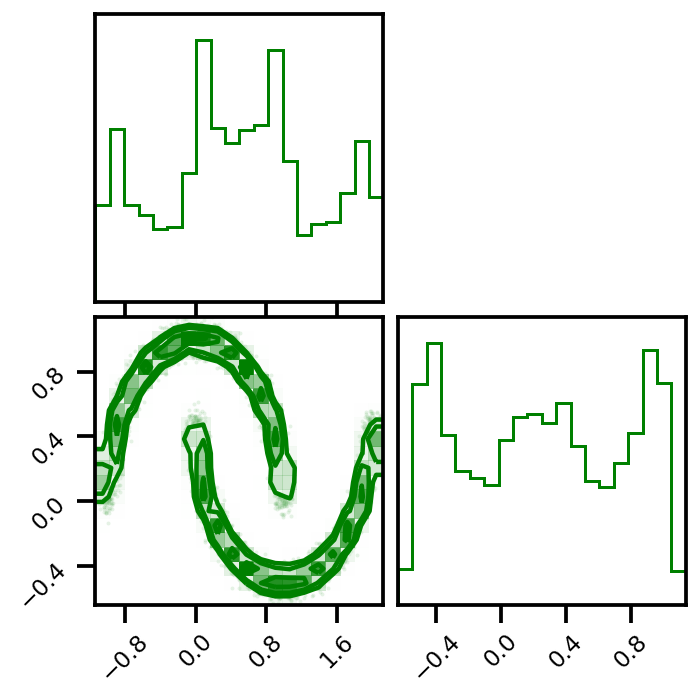

In [ ]:
fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")

#### Sampling

In [ ]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, N_DIM)
y = torch.ones((n_samples, 1))
samples, _ = inn(z, c=[y], rev=True)

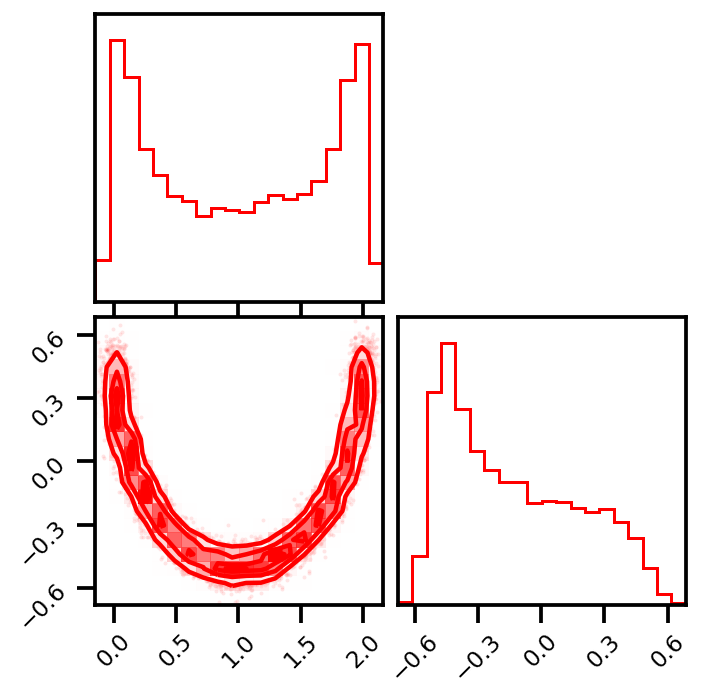

In [ ]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")

In [ ]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, N_DIM)
y = torch.zeros((n_samples, 1))
samples, _ = inn(z, c=[y], rev=True)

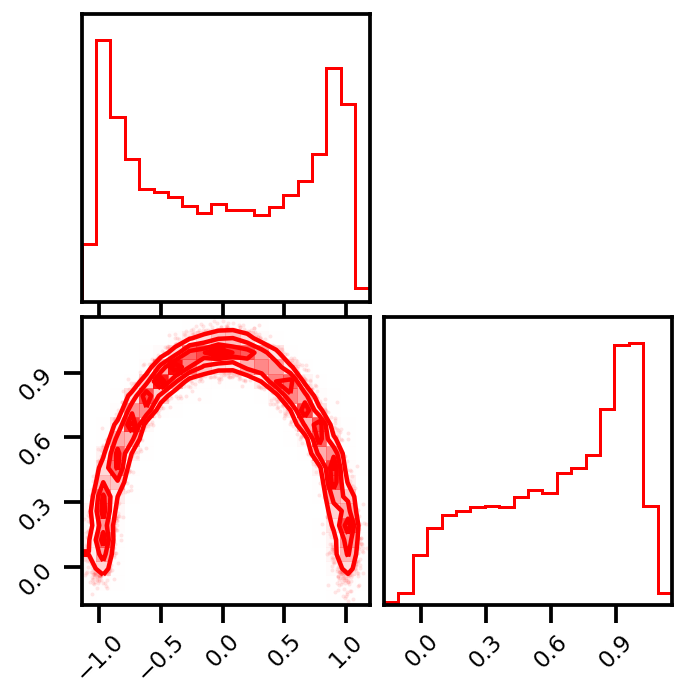

In [ ]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")

## Custom Layer

#### RQ Splines

In [ ]:
from nflows import transforms

class RQSplines(Fm.InvertibleModule):

    def __init__(
        self, 
        dims_in, 
        num_bins=10, 
        tails=None, 
        tail_bound=1.0, 
        identity_init=False,
        ):
        super().__init__(dims_in)

        self.transform = transforms.PiecewiseRationalQuadraticCDF(
            shape=dims_in[0], 
            num_bins=num_bins, 
            tails=tails, 
            tail_bound=tail_bound,
            identity_init=identity_init
            )

    def forward(self, x, rev=False, jac=True):
        # the Jacobian term is trivial to calculate so we return it
        # even if jac=False

        # x is passed to the function as a list (in this case of only on element)
        x = x[0]
        if not rev:
            # forward operation
            x, log_jac_det = self.transform.forward(x)
        else:
            # backward operation
            x, log_jac_det = self.transform.inverse(x)

        return (x,), log_jac_det

    def output_dims(self, input_dims):
        return input_dims


In [ ]:
inn = Ff.SequenceINN(N_DIM)


for k in range(20):
    inn.append(
        RQSplines, 
        num_bins=8, 
        tails="linear", 
        tail_bound=10.0, 
        identity_init=True,
    )
    # inn.append(
    #     Fm.AffineCouplingOneSided, 
    #     subnet_constructor=subnet_fc)
    inn.append(Fm.HouseholderPerm, n_reflections=4)
    
# inn.append(Ff.OutputNode, name='Output'))

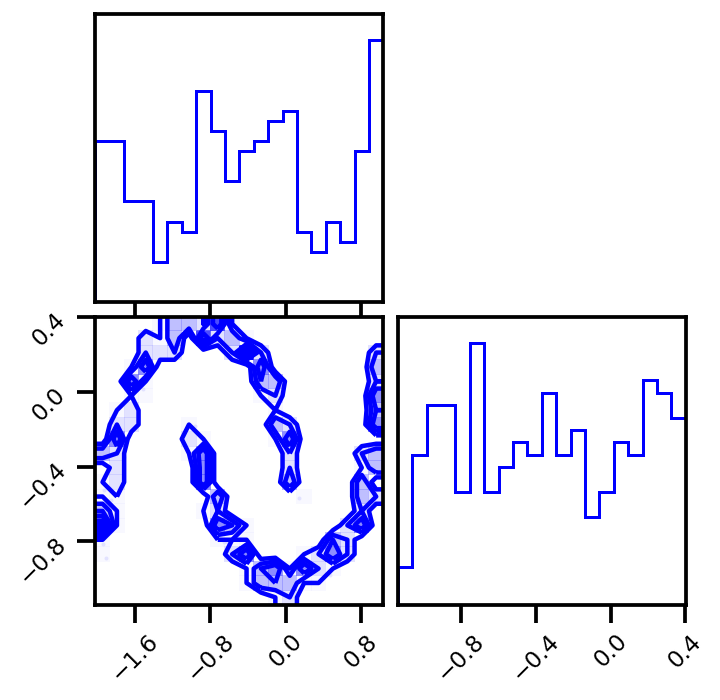

In [ ]:
x = torch.Tensor(data)
z, log_jac_det = inn(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="blue")

In [ ]:
initial_lr = 1e-2
optimizer = torch.optim.Adam(inn.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[
                0.5 * num_epochs, 
                0.75 * num_epochs,
                0.9 * num_epochs,
                ], 
    gamma=0.1)

BATCHSIZE = 256


losses = []
# a very basic training loop
with trange(num_epochs) as pbar:
    for i in pbar:
        optimizer.zero_grad()
        # sample data from the moons distribution
        data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
        x = torch.Tensor(data)
        # pass to INN and get transformed variable z and log Jacobian determinant
        z, log_jac_det = inn(x)
        # calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5*torch.sum(z**2, 1) - log_jac_det
        # loss = base_dist.log_prob(z).sum(1) - log_jac_det
        loss = loss.mean() / N_DIM
        # backpropagate and update the weights
        pbar.set_description(f"NLL Loss: {loss.item():.4f}")
        losses.append(loss.item())
        loss.backward()
        # gradient norm
        torch.nn.utils.clip_grad_norm_(inn.parameters(), max_norm=1.0, norm_type=2)
        optimizer.step()
        scheduler.step()

  0%|          | 0/2500 [00:00<?, ?it/s]

#### Losses

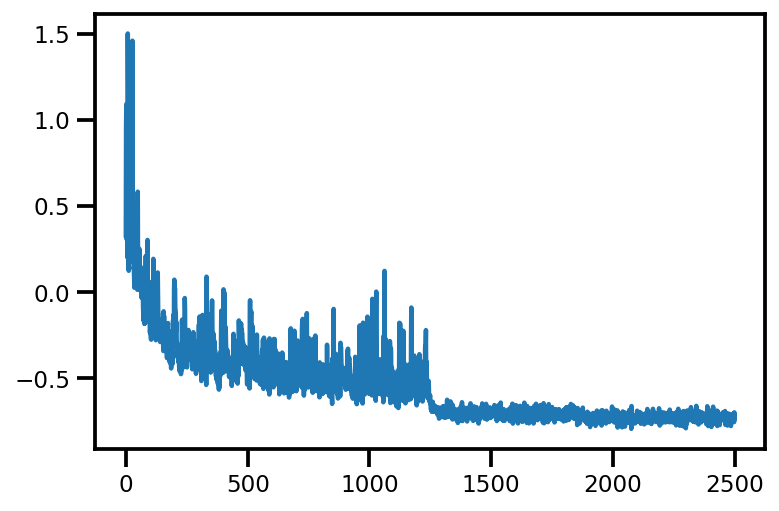

In [ ]:
plt.plot(losses)

#### Latent Domain

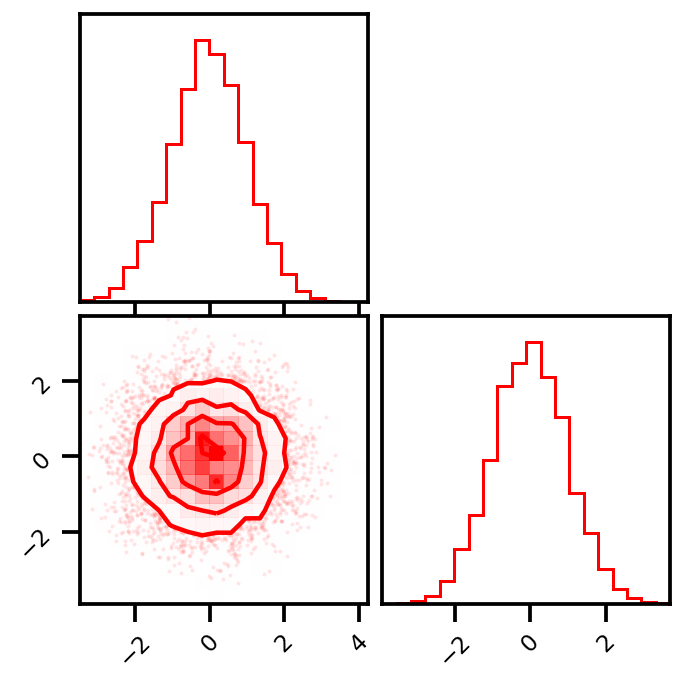

In [ ]:

n_test = 10_000
data_test, label = make_moons(n_samples=n_test, noise=0.05)
x = torch.Tensor(data_test)
z, log_jac_det = inn(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")

#### Inverse Transform

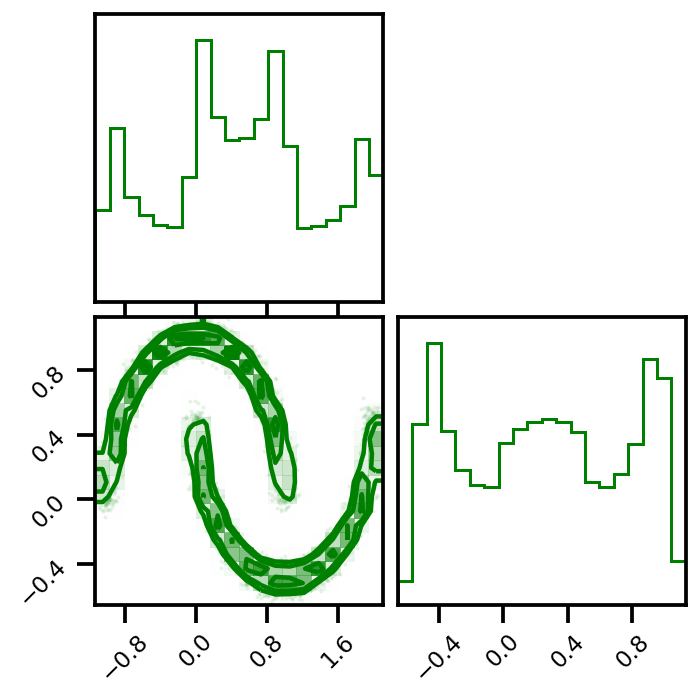

In [ ]:
x_ori, _ = inn(z,rev=True)

fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")

#### Sampling

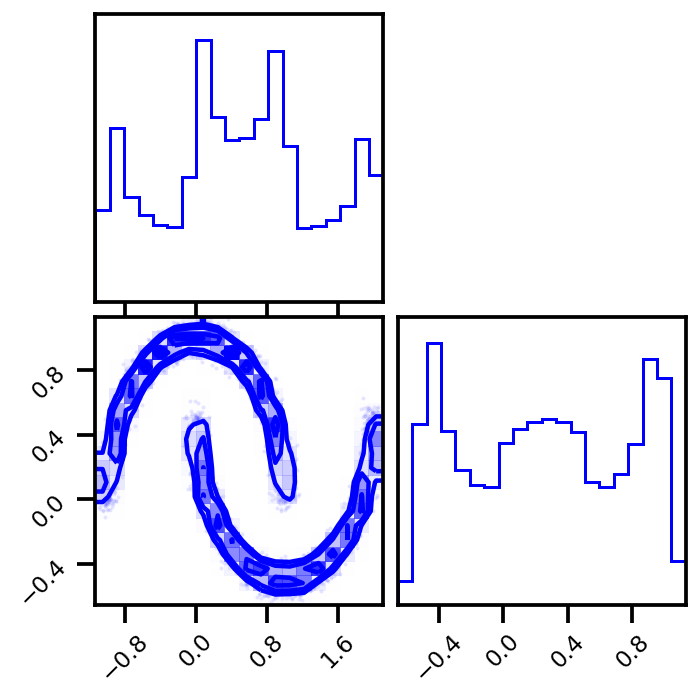

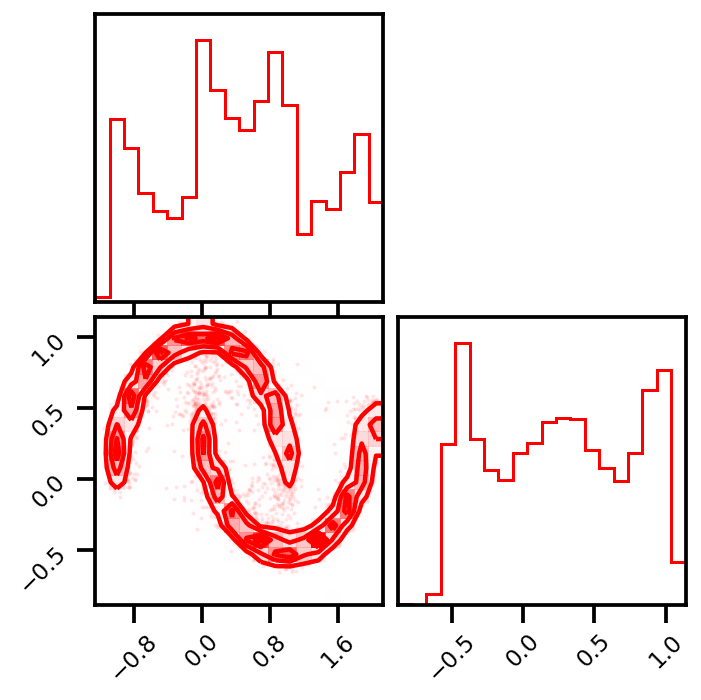

In [ ]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, N_DIM)
samples, _ = inn(z, rev=True)

fig = corner.corner(data_test, hist_factor=2, color="blue")
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")

In [ ]:
def generate_2d_grid(data: np.ndarray, n_grid: int = 1_000, buffer: float = 0.01) -> np.ndarray:

    xline = np.linspace(data[:, 0].min() - buffer, data[:, 0].max() + buffer, n_grid)
    yline = np.linspace(data[:, 1].min() - buffer, data[:, 1].max() + buffer, n_grid)
    xgrid, ygrid = np.meshgrid(xline, yline)
    xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)
    return xyinput

In [ ]:
# Read data
X_plot, _ = make_moons(n_samples=100_000, shuffle=True, noise=0.05, random_state=123 + 2)

# # sampled data
data_plot, label = make_moons(n_samples=100, noise=0.05)
xyinput = generate_2d_grid(data_plot, 500, buffer=0.1)

In [ ]:
z, log_jac_det = inn(torch.Tensor(xyinput))

In [ ]:
X_log_prob = base_dist.log_prob(z).sum(1) + log_jac_det
X_log_prob = X_log_prob.detach().numpy()

In [ ]:
X_log_prob.shape

(250000,)

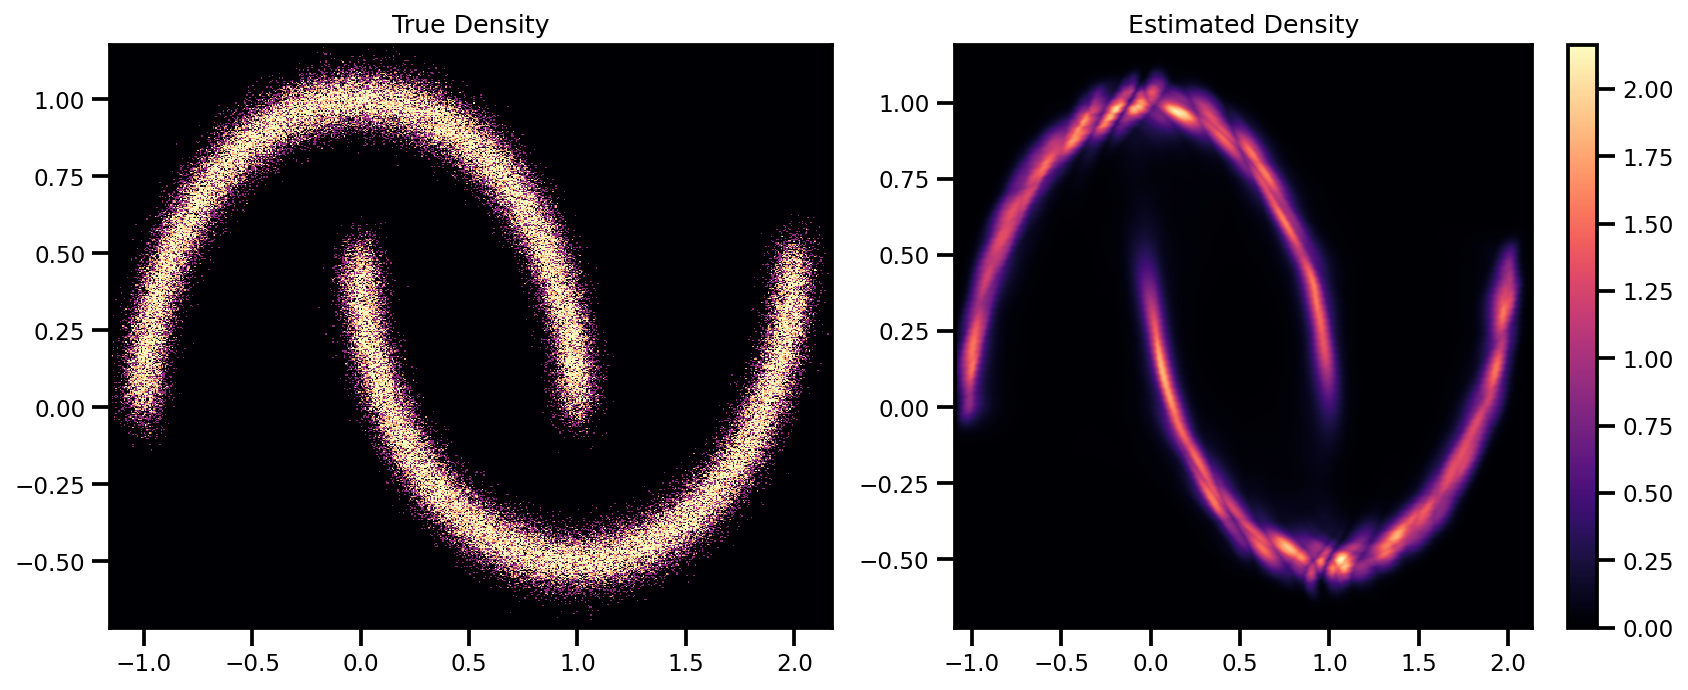

In [ ]:
from matplotlib import cm

# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = load_data(n_samples, 42)
# X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"
# cmap = "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)


h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, #vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

In [ ]:
# Input
layers = []
input = Ff.InputNode(N_DIM, name='Input')

# Input
output = Ff.OutputNode(split1.out0, name='Output 1')

In [ ]:
seed = 52199
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
X.shape

torch.Size([10000, 2])

## Logging & Parameters

## All Params

In [ ]:
# Model Params
class hparams:
    n_layers = 5
    total_datapoints = 10
    usehouseholder = False
    input_dim = 2
    process_size = batch_size
    kde_num = 5
    householder_iter = 0

    # Trainer Params
    batch_size = 100
    learning_rate = 1e-2
    weight_decay = 0.0
    beta1 = 0.9
    beta2 = 0.999
    betas = (beta1, beta2)

In [ ]:


X = torch.FloatTensor(get_classic(10_000))

X = X.to(device)

# make into dataset
train_ds = TensorDataset(X)

# make into dataloader

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

subset =  next(iter(train_dl))[0].to(device)
process_size = 100

### Define Model

In [ ]:
from models.flow_model import Net

In [ ]:


# initialize model
model = Net(100, n_layers, input_dim, kde_num, householder_iter, True, False).to(device)


#### Test Model

In [ ]:
x, log_det, _ = model.forward(X, subset, process_size=process_size)

### Optimizer

### Loss Function


In [ ]:
def flow_loss(u, log_jacob, size_average=True):
    log_probs = (-0.5 * u.pow(2) - 0.5 * np.log(2 * np.pi)).sum()
    log_jacob = log_jacob.sum()
    loss = -(log_probs + log_jacob)

    if size_average:
        loss /= u.size(0)
    return loss

### PyTorch Lightning Trainer

In [ ]:
class Learner(pl.LightningModule):
    def __init__(self, model:torch.nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = batch
        data, log_det, _ = self.model(x[0], subset, process_size=process_size)
        loss = flow_loss(data, log_det)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=0.0)

    def train_dataloader(self):
        return train_dl

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=5, max_epochs=50, progress_bar_refresh_rate=1, gpus=1)
trainer.fit(learn)

GPU available: True, used: True


2020-09-04 18:44:16,631:INFO:GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-09-04 18:44:16,633:INFO:TPU available: False, using: 0 TPU cores


CUDA_VISIBLE_DEVICES: [0]


2020-09-04 18:44:16,634:INFO:CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 10 K  


2020-09-04 18:44:16,649:INFO:
  | Name  | Type | Params
-------------------------------
0 | model | Net  | 10 K  


In [ ]:
from torch import optim



# use adam
opt = 

SyntaxError: ignored

### Training Loop

In [ ]:
epochs = 50


losses = []
model.train()
with tqdm.trange(epochs) as bar:
    # Loop through epochs with tqdm bar
    for iepoch in bar:
        # Loop through batches
        for xbatch in train_dl:

            # predictions
            data, log_det, _ = model(xbatch[0], subset, process_size=process_size)

            # loss
            loss = flow_loss(data, log_det)

            # add running loss
            losses.append(loss.item())

            # Loss back propagation
            loss.backward()

            # optimize weights
            opt.step()
            opt.zero_grad()


            postfix = dict(
                Epoch=f"{iepoch+1}", 
                Loss=f"{loss.item():.3f}",
                )
            bar.set_postfix(postfix)

 70%|███████   | 35/50 [14:24<06:10, 24.71s/it, Epoch=36, Loss=1.538]


KeyboardInterrupt: ignored

In [ ]:
plt.plot(losses)
plt.yscale("log")

### Transformation

In [ ]:
data_transform = list()
probs = list()
with torch.no_grad():
    model.eval()
    for xbatch in test_dl:

        # predictions
        data, log_det, _ = model(xbatch[0], subset, process_size=process_size)

        data_transform.append(data)
        probs.append(log_det)

In [ ]:
z = torch.cat(data_transform, dim=0).cpu().detach().numpy()
x_ljd = torch.cat(probs, dim=0).cpu().detach().numpy()

In [ ]:
# calculate the
from scipy import stats
log_prob = stats.norm.logpdf(z).sum(axis=1) + x_ljd


In [ ]:
plot_joint(z, color='blue', title='Transformed Data')

In [ ]:
plot_joint_prob(X.cpu().detach().numpy(), log_prob,title='Log Probability')

In [ ]:
plot_joint_prob(X.cpu().detach().numpy(), np.exp(log_prob),title='Probability')

### Sampling

In [ ]:
prior_dist = torch.distributions.Normal(loc=0.0, scale=1.0)
prior_dist.sample((1,1))

In [ ]:
eval_size = 5_000

with torch.no_grad():
    model.eval()
    prior = prior_dist.sample((eval_size,2)).to(device)

    x_samples = model.sampling(
        subset,
        prior,
        process_size=eval_size,
        sample_num=eval_size
    )

In [ ]:
plot_joint(x_samples.cpu().detach().numpy(), color='blue', title='Sampled')

In [ ]:
plt.hist(x_samples.cpu().detach().numpy()[:,0])

In [ ]:
plt.hist(x_samples.cpu().detach().numpy()[:,1])

In [ ]:
from pytorch_lightning import Trainer



trainer = Trainer(max_nb_epochs=500)
trainer.fit(gp_model)
print('lengthscale: %.3f   noise: %.3f' % (
        gp_model.model.covar_module.base_kernel.lengthscale.item(),
        gp_model.model.likelihood.noise.item()
    ))
%tensorboard --logdir lightning_logs/

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Gaussian Mixture Model

In [ ]:
tfd = tfp.distributions

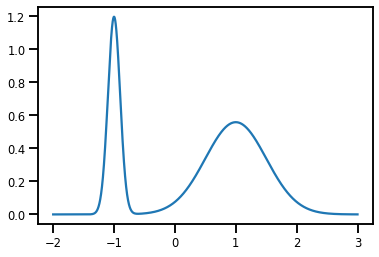

In [ ]:
mix = 0.3
bimix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=[mix, 1. - mix]),
    components=[
                tfd.Normal(loc=-1., scale=0.1),
                tfd.Normal(loc=+1., scale=0.5),
    ]
)

# Plot the PDF
x = tf.linspace(-2., 3., int(1e4)).numpy()

plt.plot(x, bimix_gauss.prob(x).numpy())

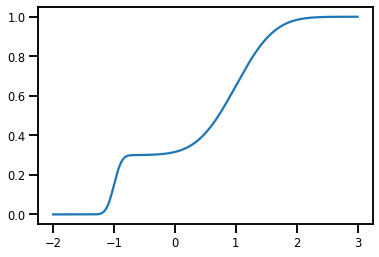

In [ ]:
plt.plot(x, bimix_gauss.cdf(x).numpy())

In [ ]:
p = tf.linspace(0.111, 0.9999, int(1e4)).numpy()

plt.plot(p, bimix_gauss.quantile(p).numpy())

NotImplementedError: ignored